Import libraries and clean data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

Load in data

In [16]:
data_read = pd.read_csv('All Trading Simulation Output B.csv')
data_read = data_read.drop(columns=['Unnamed: 0'])
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%d/%m/%Y %H:%M')
signal_counts = data_read['Trading Signal'].value_counts()
print(signal_counts)

Trading Signal
Hold    62399
Buy       582
Sell      246
Name: count, dtype: int64


Get extra features 

In [17]:
# time
data_read['Hour'] = data_read['DateTime_Minute'].dt.hour
data_read['Minute'] = data_read['DateTime_Minute'].dt.minute
data_read['Second'] = data_read['DateTime_Minute'].dt.second

# moving averages for bid and ask prices
data_read['MA5_Bid'] = data_read['Bid1_Price'].rolling(window=5).mean()
data_read['MA10_Bid'] = data_read['Bid1_Price'].rolling(window=10).mean()
data_read['MA5_Ask'] = data_read['Ask1_Price'].rolling(window=5).mean()
data_read['MA10_Ask'] = data_read['Ask1_Price'].rolling(window=10).mean()

# lagged features
data_read['Weighted_Avg_Bid_Price_Lag1'] = data_read['Bid1_Price'].shift(1)
data_read['Weighted_Avg_Ask_Price_Lag1'] = data_read['Ask1_Price'].shift(1)

Make data cutes for Train, Val, Test

In [18]:
# Train: Jan - April
train_data = data_read[data_read['DateTime_Minute'] <= '2025-05-31'].copy()
# Val: May
#validation_data = data_read[(data_read['DateTime_Minute'] >= '2025-01-03') & (data_read['DateTime_Minute'] < '2025-01-04')].copy()
validation_data = data_read[(data_read['DateTime_Minute'] >= '2025-05-01') & (data_read['DateTime_Minute'] < '2025-06-01')].copy()
# Test: June
#test_data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()
test_data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()

Select Features and target variable

In [19]:
# define the target
target = 'Trading Signal'

# select features
features = ['Bid1_Price', 'Bid2_Price', 'Ask1_Price', 'Ask2_Price', 'Bid1_Volume', 'Ask1_Volume', 
            'Bid_Ask_Spread', 'Market_Depth_Bid', 'Market_Depth_Ask', 
            'Historical_Volatility', 'Cumulative_Volume_Difference', 'Order_imbalance', 
            'MA5_Bid', 'MA10_Bid', 'MA5_Ask', 'MA10_Ask', 'RSI', 'MACD', 
            'Weighted_Avg_Bid_Price_Lag1', 'Weighted_Avg_Ask_Price_Lag1']


X_train = train_data[features]
y_train = train_data[target]

X_val = validation_data[features]
y_val = validation_data[target]

X_test = test_data[features]
y_test = test_data[target]

Fill missing values with medians

In [20]:
# use SimpleImputer to impute medians
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


Handle Class Imbalances using SMOTE

In [21]:
# use smote to resample training data 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

In [22]:
# Print the distribution of classes after SMOTE
print(y_train_resampled.value_counts())

Trading Signal
Hold    51793
Buy     51793
Sell    51793
Name: count, dtype: int64


Scale Model (not neccesarily needed)

In [23]:
# scale data (not really needed for RF, but could be useful to expand to other models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [24]:
# Count occurrences of each unique value in y_train_resampled
counts = y_train.value_counts()

# Print the number of "Buy" signals
print("Number of 'Buy' signals in y_train_resampled:", counts.get('Hold', 0))

Number of 'Buy' signals in y_train_resampled: 51793


In [25]:
# simple RF to assess feature 
rf_simple = RandomForestClassifier(n_estimators=100, random_state=42)
rf_simple.fit(X_train_scaled, y_train_resampled)
importances = rf_simple.feature_importances_

# print feature importance
feature_names = features
sorted_indices = np.argsort(importances)[::-1]
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.2f}")

RSI: 0.57
MACD: 0.13
Bid_Ask_Spread: 0.10
Historical_Volatility: 0.05
Ask1_Price: 0.02
Ask2_Price: 0.02
MA10_Bid: 0.01
Cumulative_Volume_Difference: 0.01
Market_Depth_Bid: 0.01
Order_imbalance: 0.01
Market_Depth_Ask: 0.01
Bid1_Volume: 0.01
MA5_Bid: 0.01
Weighted_Avg_Bid_Price_Lag1: 0.01
Bid2_Price: 0.01
Ask1_Volume: 0.01
Bid1_Price: 0.01
Weighted_Avg_Ask_Price_Lag1: 0.00
MA10_Ask: 0.00
MA5_Ask: 0.00


Do Gridsearch to get best params

In [28]:
from sklearn.model_selection import GridSearchCV

# gridseach parameters
param_grid = {
    'n_estimators': [200, 300, 400],  # no.of trees
    'max_depth': [20, 30, 40],  # max depth of the tree
    'min_samples_split': [2, 5],  # min no. samples required to split an internal node
    'min_samples_leaf': [1, 2]  # min no. of samples required at a leaf node
}

# RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy', n_jobs=-1)

Print Best Params

In [29]:
# fit grid search
grid_search.fit(X_train_scaled, y_train_resampled)

# print best parameters and score from grid search
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best cross-validation score: 0.99


Get validation accuracy using grid search parameters

In [30]:
# predict and evaluate
y_val_pred = grid_search.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 1.0


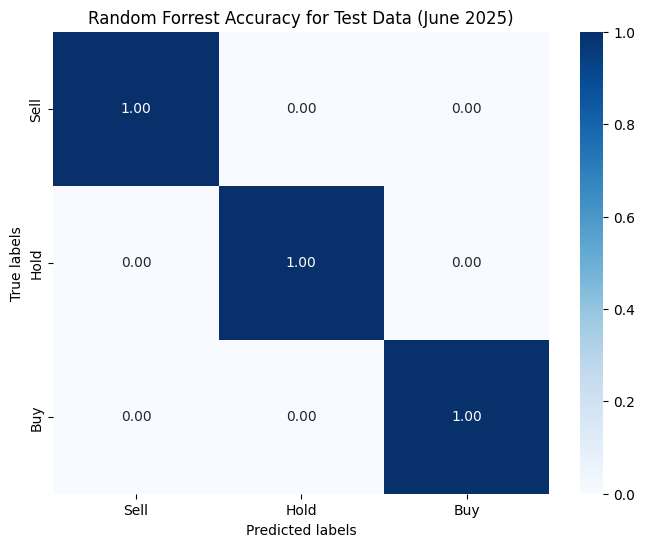

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# onfusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forrest Accuracy for Test Data (June 2025)')
ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])

plt.show()

Do on Test Data

In [32]:
# predict and evaluate
y_test_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)


Test set accuracy: 0.9859010270774977


In [37]:
from sklearn.metrics import f1_score
best_rf_model = grid_search.best_estimator_
# Predictusing best model
y_test_pred = best_rf_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)
test_f1_score = f1_score(y_test, y_test_pred, average='macro')
print("Test set F1 Score:", test_f1_score)

Test set accuracy: 0.9859010270774977
Test set F1 Score: 0.5087363371864434


In [36]:
results_df = pd.DataFrame({'True_Label': y_test, 'Predicted_Label': y_test_pred})
results_df.to_csv('Random Forest Test Results B.csv', index=False)

Plot Result

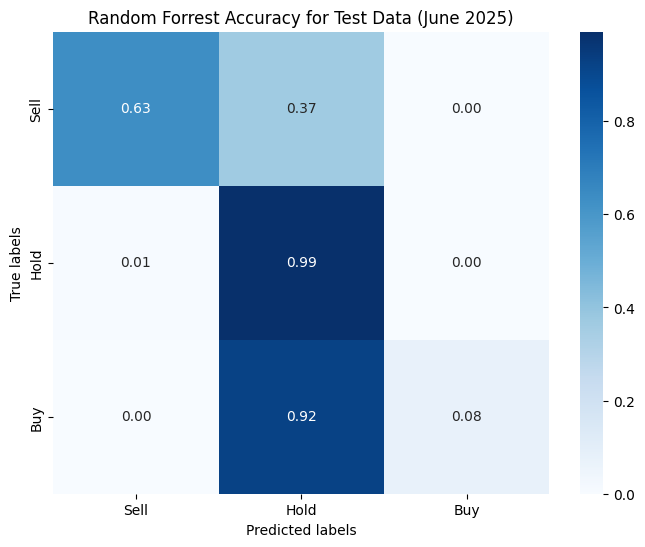

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forrest Accuracy for Test Data (June 2025)')
ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])

plt.show()

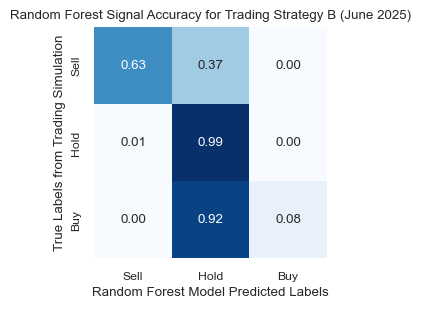

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set(font_scale=0.8)
cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".2f", cbar = False)
ax.set_xlabel('Random Forest Model Predicted Labels')
ax.set_ylabel('True Labels from Trading Simulation')
ax.set_title('Random Forest Signal Accuracy for Trading Strategy B (June 2025)')
ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
plt.savefig('Random Forest Matrix - Test Results B.png', dpi=600, bbox_inches='tight')
plt.show()

In [29]:
plt.savefig('Random Forest - Test Results.png')

<Figure size 640x480 with 0 Axes>

In [22]:
# predict and evaluate
y_test_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.6986928104575163


Plot the tree

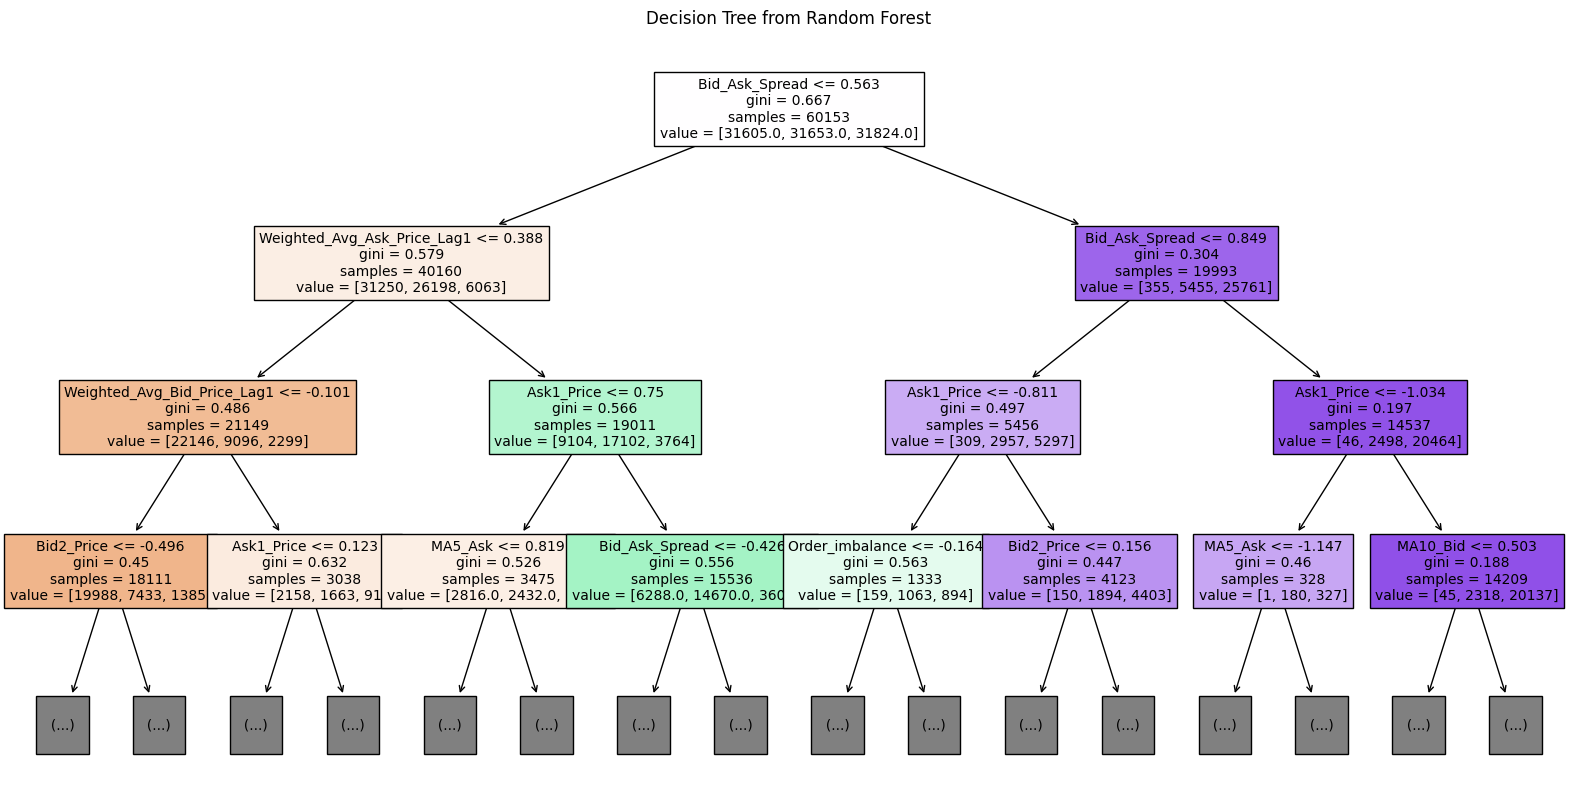

In [23]:
from sklearn.tree import plot_tree

best_rf_model = grid_search.best_estimator_
# first tree

first_tree = best_rf_model.estimators_[0]
# plot tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(first_tree, filled=True, feature_names=features, max_depth=3, fontsize=10, ax=ax)
plt.title("Decision Tree from Random Forest")
plt.show()